# Penrose Tiling from Five Dimensions

Adapted from the youtube video by NumberCruncher, "Penrose Tilings from Five Dimensions

In [1]:
import numpy as np

from scipy.spatial import ConvexHull

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from itertools import chain, combinations

# https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset
# modified to give subsets of maximum length "n"
def subSet(iterable,n):
    "subSet([1,2,3],2) --> (1,2) (1,3) (2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(n,n+1))

pi_unicode = "\u03C0"

In [2]:
from scipy import linalg

In [3]:
rotationMatrix = np.array([[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,1.,0.],[0.,0.,0.,0.,1.],[1.,0.,0.,0.,0.]])
# Senechal
# rotationMatrix = np.array([[0.,0.,0.,0.,1.],[1.,0.,0.,0.,0.],[0.,1.,0.,0.,0.],[0.,0.,1.,0.,0.],[0.,0.,0.,1.,0.]])

In [4]:
rotationMatrix

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])

In [5]:
eigenValues, eigenVectors = np.linalg.eig(rotationMatrix)

# idx = np.argsort(eigenValues)
# eigenValues = eigenValues[idx]
# eigenVectors = eigenVectors[:,idx]

for i in range(5):
    print(i)
    print('  :', eigenVectors[:,i].real/np.linalg.norm(eigenVectors[:,i].real) )
    print('  :',  eigenVectors[:,i].imag/np.linalg.norm(eigenVectors[:,i].imag) )

0
  : [-0.19543951  0.51166727 -0.63245553  0.51166727 -0.19543951]
  : [-0.60150096  0.37174803  0.         -0.37174803  0.60150096]
1
  : [-0.19543951  0.51166727 -0.63245553  0.51166727 -0.19543951]
  : [ 0.60150096 -0.37174803 -0.          0.37174803 -0.60150096]
2
  : [ 0.63245553  0.19543951 -0.51166727 -0.51166727  0.19543951]
  : [ 0.          0.60150096  0.37174803 -0.37174803 -0.60150096]
3
  : [ 0.63245553  0.19543951 -0.51166727 -0.51166727  0.19543951]
  : [-0.         -0.60150096 -0.37174803  0.37174803  0.60150096]
4
  : [0.4472136 0.4472136 0.4472136 0.4472136 0.4472136]
  : [nan nan nan nan nan]


/var/folders/40/cbx_ffsn4gg4l3qsn4dr99xm0000gn/T/ipykernel_34647/499469937.py:10: RuntimeWarning: invalid value encountered in divide
  print('  :',  eigenVectors[:,i].imag/np.linalg.norm(eigenVectors[:,i].imag) )


### Projector

In [6]:
k, l = 2, 3
u,v = (eigenVectors[:,k]+eigenVectors[:,l]).real, (1j*(eigenVectors[:,k]-eigenVectors[:,l])).real
u /= np.linalg.norm(u)
v /= np.linalg.norm(v)
p = np.vstack((u,v))

e1 = p@np.array([0,1,0,0,0])
e2 = p@np.array([0,0,1,0,0])
e1 = e1/np.linalg.norm(e1)
e2 = e2/np.linalg.norm(e2)

p_rotation = np.arccos(np.dot(e1,e2))*(5/np.pi)
print(f'Basis vectors are rotated in projection plane by ({p_rotation}{pi_unicode})/5')
p

Basis vectors are rotated in projection plane by (2.0π)/5


array([[ 0.63245553,  0.19543951, -0.51166727, -0.51166727,  0.19543951],
       [ 0.        , -0.60150096, -0.37174803,  0.37174803,  0.60150096]])

### Convex hull for point selection
3D space of second projection plane (orthogonal to first) and vector [1,1,1,1,1]

In [7]:
k, l = 1, 0
u,v = (eigenVectors[:,k]+eigenVectors[:,l]).real, (1j*(eigenVectors[:,k]-eigenVectors[:,l])).real
u /= np.linalg.norm(u)
v /= np.linalg.norm(v)

e1 = p@np.array([0,1,0,0,0])
e2 = p@np.array([0,0,1,0,0])
e1 = e1/np.linalg.norm(e1)
e2 = e2/np.linalg.norm(e2)

y_rotation = np.arccos(np.dot(e1,e2))*(5/np.pi)
print(f'Basis vectors are rotated in projection plane by ({y_rotation}{pi_unicode})/5')

y = np.vstack((u,v,np.array([1,1,1,1,1])/np.linalg.norm(np.array([1,1,1,1,1]))))
y

Basis vectors are rotated in projection plane by (2.0π)/5


array([[-0.19543951,  0.51166727, -0.63245553,  0.51166727, -0.19543951],
       [-0.60150096,  0.37174803,  0.        , -0.37174803,  0.60150096],
       [ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ]])

In [8]:
# # 0,1 eigenvalues project where basis vectors are rotated by 4pi/5, 2,3 eigenvalues to 2pi/5

# # i = 0
# i = 3
# # i = 2
# # i = 3
# u = eigenVectors[:,i].real/np.linalg.norm(eigenVectors[:,i].real)
# v = eigenVectors[:,i].imag/np.linalg.norm(eigenVectors[:,i].imag)

# p = np.vstack((u,v))
# p

In [9]:
# # i=3
# i=0
# # i = 1
# y = np.array(
#     (
#         eigenVectors[:,i].real/np.linalg.norm(eigenVectors[:,i].real),
#         eigenVectors[:,i].imag/np.linalg.norm(eigenVectors[:,i].imag),
#         np.array([1,1,1,1,1])/np.linalg.norm(np.array([1,1,1,1,1]))
#     )
# )
# y

In [10]:
voronoiCell = np.zeros((32,5))
s = 0.999
i = 0
for i5 in range(2):
    for i4 in range(2):
        for i3 in range(2):
            for i2 in range(2):
                for i1 in range(2):
                    voronoiCell[i,:] = s*np.array([i1,i2,i3,i4,i5])
                    i += 1

In [11]:
convexHullSeed = (y@voronoiCell.T).T

In [12]:
hull = ConvexHull(convexHullSeed)

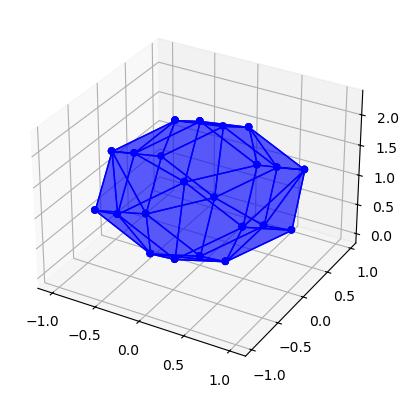

In [13]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")

pts = convexHullSeed
for s in hull.simplices:
    tri = Poly3DCollection([pts[s]])
    tri.set_color('blue')
    tri.set_alpha(0.4)
    ax.add_collection3d(tri)
    ax.scatter(pts[s, 0], pts[s, 1], pts[s, 2], marker='o', color='blue')
    # s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    # ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r")


In [14]:
# https://stackoverflow.com/questions/16750618/whats-an-efficient-way-to-find-if-a-point-lies-in-the-convex-hull-of-a-point-cl

def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [15]:
z5 = np.zeros((161051,5))
i = 0
for i5 in range(-5,6):
    for i4 in range(-5,6):
        for i3 in range(-5,6):
            for i2 in range(-5,6):
                for i1 in range(-5,6):
                    z5[i,:] = np.array([i1+0.2,i2+0.2,i3+0.2,i4+0.2,i5-0.8])
                    i += 1

z5Projected = (y@z5.T).T

In [16]:
inHullIndices = in_hull(z5Projected,convexHullSeed[hull.vertices])

In [17]:
selPoints = z5[inHullIndices,:]

In [18]:
(selPoints-np.array([0.2,0.2,0.2,0.2,-0.8])).min(axis=0),(selPoints-np.array([0.2,0.2,0.2,0.2,-0.8])).max(axis=0)

(array([-5., -5., -5., -5., -5.]), array([5., 5., 5., 5., 5.]))

In [19]:
xy = (p@selPoints.T).T

(np.float64(-9.710401058852932),
 np.float64(8.8825060192344),
 np.float64(-10.06188392371096),
 np.float64(8.487133979235685))

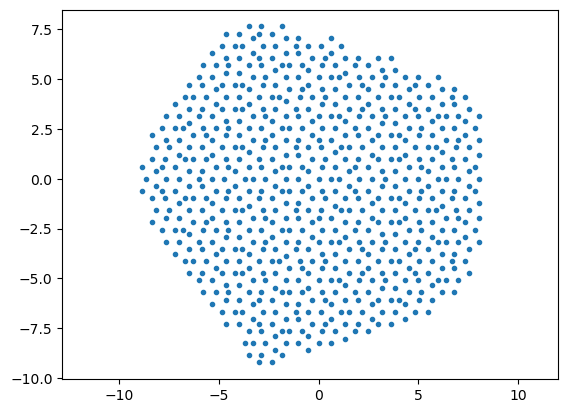

In [20]:
plt.plot(xy[:,0],xy[:,1],'.')
plt.axis('equal')

### Construct the tiling

In [21]:
spans = list(subSet([0,1,2,3,4],2))
e = np.identity(5)

In [22]:
def unitVector(l,d):
    u = np.zeros(l)
    u[d] = 1.0
    return u

def polygonDataFunction(point,dir_):
    return np.array( [point, point+unitVector(5,dir_[0]), point+unitVector(5,dir_[0])+unitVector(5,dir_[1]), point+unitVector(5,dir_[1])] )

def nMemberQ(set_,point_):
    # Check if point_ is contained in the set_
    member = np.any(np.sum(np.abs(set_-point_),1) < 1e-6)
    return member

In [23]:
for dir_ in spans:
    print(dir_)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(1, 2)
(1, 3)
(1, 4)
(2, 3)
(2, 4)
(3, 4)


In [24]:
xy.max()

np.float64(8.03737387932134)

In [25]:
from matplotlib.patches import Rectangle, Circle, Polygon

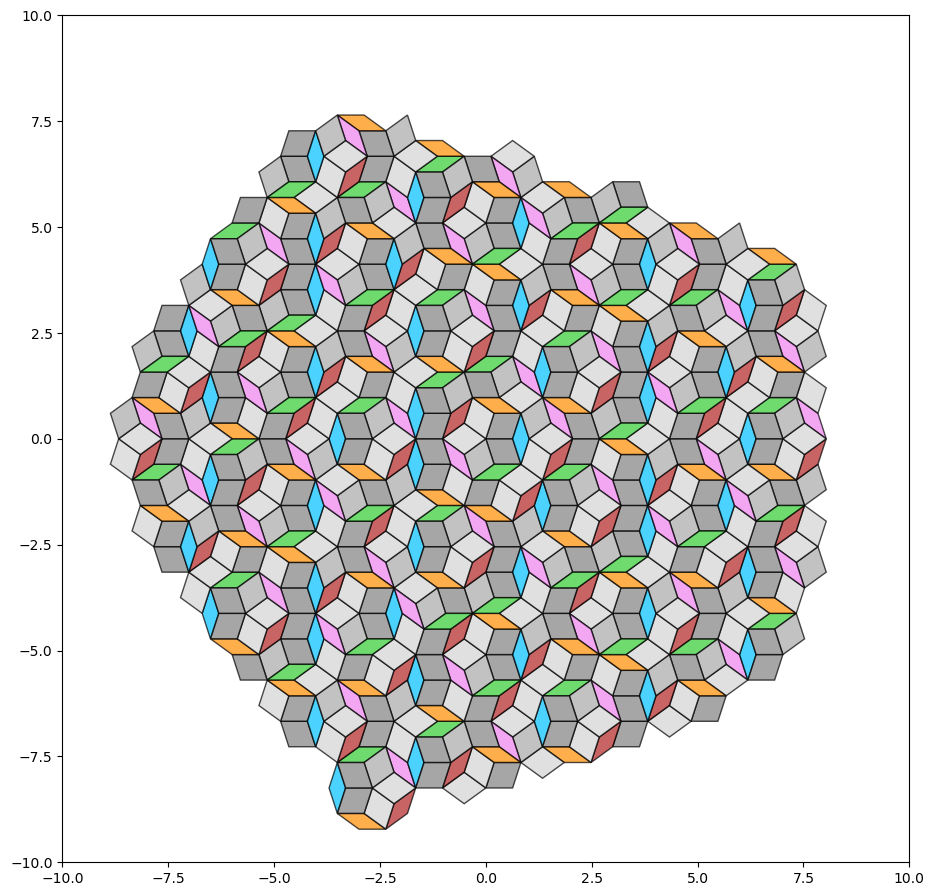

In [26]:
clrs = ['grey','limegreen','darkorange','grey','darkgrey','violet','deepskyblue','lightgrey',
 'firebrick',
 'lightgrey'
 ]

fig, ax = plt.subplots(figsize=(11, 11))

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal')

n_tiles = 0

for pt in selPoints:
    for d_, dir_ in enumerate(spans):
        tile = polygonDataFunction(pt,dir_)
        in_base = np.all((
            nMemberQ(selPoints,tile[0]),
            nMemberQ(selPoints,tile[1]),
            nMemberQ(selPoints,tile[2]),
            nMemberQ(selPoints,tile[3]))
                        )
        if in_base:
            t = (p@tile.T).T
            polygon = Polygon(t, 
                  edgecolor='black', facecolor=clrs[d_],alpha=0.7)
            ax.add_patch(polygon)

            n_tiles += 1
            
        

In [27]:
(selPoints-np.array([0.2,0.2,0.2,0.2,-0.8])).min(axis=0),(selPoints-np.array([0.2,0.2,0.2,0.2,-0.8])).max(axis=0)

(array([-5., -5., -5., -5., -5.]), array([5., 5., 5., 5., 5.]))

In [28]:
(selPoints-np.array([0.2,0.2,0.2,0.2,-0.8]))

array([[-1.,  5.,  4., -2., -5.],
       [-2.,  5.,  5., -2., -5.],
       [-1.,  5.,  5., -2., -5.],
       ...,
       [-3., -5.,  0.,  5.,  5.],
       [-2., -5.,  0.,  5.,  5.],
       [-2., -4.,  0.,  5.,  5.]], shape=(673, 5))

In [29]:
n_tiles

622

In [30]:
tileCoordinates = np.zeros((n_tiles,8))
tileIndices = np.zeros((n_tiles,20))
tileFaceDirection = np.zeros((n_tiles))

n_ = 0

for pt in selPoints:
    for d_, dir_ in enumerate(spans):
        tile = polygonDataFunction(pt,dir_)
        in_base = np.all((
            nMemberQ(selPoints,tile[0]),
            nMemberQ(selPoints,tile[1]),
            nMemberQ(selPoints,tile[2]),
            nMemberQ(selPoints,tile[3]))
                        )
        if in_base:
            t = (p@tile.T).T

            tileCoordinates[n_,0:2] = t[0,:]
            tileCoordinates[n_,2:4] = t[1,:]
            tileCoordinates[n_,4:6] = t[3,:]   # note reordering to be consistent with supercollider code convention
            tileCoordinates[n_,6:8] = t[2,:]
            
            t_ = (tile-np.array([0.2,0.2,0.2,0.2,-0.8])).astype(int)
            tileIndices[n_,0:5]   = t_[0,:]
            tileIndices[n_,5:10]  = t_[1,:]
            tileIndices[n_,10:15] = t_[3,:]   # note reordering to be consistent with supercollider code convention
            tileIndices[n_,15:20] = t_[2,:]

            tileFaceDirection[n_] = d_
            
            n_ += 1


In [33]:
dir = 'Data/'
np.savetxt(dir+'verts_5Dprojection.txt',tileCoordinates,fmt='%.8e',delimiter=',')
np.savetxt(dir+'indices_5Dprojection.txt',tileIndices,fmt='%d',delimiter=',')
np.savetxt(dir+'faces_5Dprojection.txt',tileFaceDirection,fmt="%d")